In [1]:
import pandas as pd
import numpy as np
np.__version__
import matplotlib.pyplot as plt
_FOLDER = "../data/"
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor
from scipy.optimize import curve_fit
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import \
    KFold, RepeatedKFold, GridSearchCV, \
    cross_validate, train_test_split
import json
from skopt import BayesSearchCV


In [2]:
def createResponseCurve(iD,model, xValues, yValues, predicted = False):
#     fig = plt.figure(figsize=(5, 5))
    plt.scatter(xValues, yValues)
    plt.title(model + " " + iD)
    plt.xlabel("Scaled dosage")
    if(predicted):
        plt.ylabel("Predicted Normalised response")
    else:
        plt.ylabel("Normalised response")
    plt.show()


with open(_FOLDER + 'dataSplit.json') as json_file:
    trainTestSplit = json.load(json_file)

In [3]:
drugProfiles = pd.read_csv(_FOLDER+'filteredResponsesWithCCLAndParams.csv')
drugProfiles

,CELL_LINE_NAME,COSMIC_ID,DRUG_ID,DRUGID_COSMICID,MAX_CONC,fd_num_0,fd_num_1,fd_num_2,fd_num_3,fd_num_4,...,chr9:104248247-104249501(C9orf125)_HypMET,"chr9:115875199-115875738(C9orf109, C9orf110)_HypMET",chr9:123555399-123555899(FBXW2)_HypMET,chr9:140310894-140312457(EXD3)_HypMET,chr9:21974578-21975306(CDKN2A)_HypMET,chr9:35756948-35757339(MSMP)_HypMET,chr9:35791584-35791924(NPR2)_HypMET,chr9:4984543-4985630(JAK2)_HypMET,chr9:86571047-86572027(C9orf64)_HypMET,chr9:98783216-98784364(NCRNA00092)_HypMET
0,HDQ-P1,1290922,344,344_1290922,20.00,0,0.111111,0.222222,0.333333,0.444444,...,0,0,0,0,0,0,0,0,0,0
1,HDQ-P1,1290922,136,136_1290922,16.00,0,0.111111,0.222222,0.333333,0.444444,...,0,0,0,0,0,0,0,0,0,0
2,HDQ-P1,1290922,170,170_1290922,16.00,0,0.111111,0.222222,0.333333,0.444444,...,0,0,0,0,0,0,0,0,0,0
3,NMC-G1,908449,170,170_908449,16.00,0,0.111111,0.222222,0.333333,0.444444,...,0,0,0,0,0,0,0,0,1,0
4,NMC-G1,908449,331,331_908449,10.24,0,0.111111,0.222222,0.333333,0.444444,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5579,TC-YIK,946357,1011,1011_946357,2.00,0,0.111111,0.222222,0.333333,0.444444,...,0,0,0,0,0,0,0,0,0,0
5580,MKN45,925340,1149,1149_925340,5.00,0,0.111111,0.222222,0.333333,0.444444,...,0,0,0,0,0,0,0,0,0,0
5581,EC-GI-10,753555,1004,1004_753555,0.10,0,0.111111,0.222222,0.333333,0.444444,...,0,0,0,0,0,0,0,0,0,0
5582,IGROV-1,905968,1031,1031_905968,0.20,0,0.111111,0.222222,0.333333,0.444444,...,0,0,0,0,0,0,0,0,0,0


In [4]:
len(trainTestSplit.keys())

88

In [5]:
# filterPlateau = filterPlateau[~filterPlateau['DRUG_ID'].isin(toDropDrugs)]
params = ['param_1', 'param_2','param_3','param_4']
notIncludeColumns = ['CELL_LINE_NAME', 'COSMIC_ID', 'DRUG_ID', 'DRUGID_COSMICID','MAX_CONC']+params
conc_labels = ["fd_num_"+str(i) for i in range(10)]
resp_labels = ['norm_cells_'+str(i) for i in range(10)]
pred_resp_labels = ['pred_norm_cells_'+str(i) for i in range(10)]
fullPredLabels = ['DRUG_COSMICID'] + pred_resp_labels
ridgeResults = pd.DataFrame(columns=fullPredLabels)
lassoResults = pd.DataFrame(columns=fullPredLabels)
svmResults = pd.DataFrame(columns=fullPredLabels)

combinedResults = pd.DataFrame(columns=fullPredLabels)
trueResults = pd.DataFrame(columns= ['DRUG_COSMICID']+ resp_labels + params)
df = None
drugId = 344
drugProfile = drugProfiles[drugProfiles['DRUG_ID'] == int(drugId)]
trainData = drugProfile[drugProfile['DRUGID_COSMICID'].isin(trainTestSplit[str(drugId)][0])]
testData = drugProfile[drugProfile['DRUGID_COSMICID'].isin(trainTestSplit[str(drugId)][1])]
testDataCosmicIds = np.array(testData['DRUGID_COSMICID'])
notXValuesFilter = resp_labels + notIncludeColumns + conc_labels
trainXValues = trainData.drop(columns = notXValuesFilter)
trainYValues = trainData[resp_labels]

trainX = trainXValues.reset_index(drop=True).to_numpy()
trainY = trainYValues.reset_index(drop=True).to_numpy()

testXValues = testData.drop(columns = notXValuesFilter)
testYValues = testData[resp_labels]
testParamsValues = testData[params]

testX = testXValues.reset_index(drop=True).to_numpy()
testY = testYValues.reset_index(drop=True).to_numpy()
testParams = testParamsValues.reset_index(drop=True).to_numpy()

cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
ridge_alphas = np.linspace(100, 140, 80)
ridge = Ridge()
grid = dict()
grid['alpha'] = ridge_alphas
gscv = GridSearchCV( \
    ridge, grid, scoring='neg_mean_absolute_error', \
    cv=cv, n_jobs=-1)
results = gscv.fit(trainX, trainY)
print(results.best_params_)

ridge = Ridge(alpha=results.best_params_['alpha'])
ridge.fit(trainX, trainY)
pred_train = ridge.predict(trainX)
pred_test= ridge.predict(testX)
resultsRidge = pd.DataFrame(testDataCosmicIds, columns=['DRUG_COSMICID'])
resultsRidge[pred_resp_labels] = pred_test
ridgeResults = ridgeResults.append(resultsRidge,ignore_index=True,sort=False)

cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
lasso_alphas = np.linspace(0, 10, 20)
lasso = Lasso()
grid = dict()
grid['alpha'] = lasso_alphas
gscv = GridSearchCV( \
    lasso, grid, scoring='neg_mean_absolute_error', \
    cv=cv, n_jobs=-1)
results = gscv.fit(trainX, trainY)
print(results.best_params_)

lasso = Lasso(alpha=results.best_params_['alpha'])
lasso.fit(trainX, trainY)
pred_trainL = lasso.predict(trainX)
pred_testL= lasso.predict(testX)
resultsLasso = pd.DataFrame(testDataCosmicIds, columns=['DRUG_COSMICID'])
resultsLasso[pred_resp_labels] = pred_testL
lassoResults = lassoResults.append(resultsLasso,ignore_index=True,sort=False)

searchSpace = {
    'estimator__C': (0.1, 10.0),
    'estimator__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'estimator__gamma': (0.001, 1.0),
    'estimator__degree': (2, 4),
    'estimator__epsilon': (0.01, 0.5)
}
valModel = MultiOutputRegressor(SVR())
bayes = BayesSearchCV(valModel, searchSpace, cv=5, n_iter=20, n_jobs=-1)
bayes.fit(trainX, trainY)
print("Best hyperparameters: ", bayes.best_params_)
bestParams = bayes.best_params_
svm = MultiOutputRegressor(SVR(kernel=bestParams['estimator__kernel'], 
                            C=bestParams['estimator__C'],
                            gamma=bestParams['estimator__gamma'],
                            degree=bestParams['estimator__degree'],
                            epsilon=bestParams['estimator__epsilon']
                        ))
svm.fit(trainX, trainY)

pred_testSVM = svm.predict(testX)

svmResult = pd.DataFrame(testDataCosmicIds, columns=['DRUG_COSMICID'])
svmResult[pred_resp_labels] = pred_testSVM
svmResults = svmResults.append(svmResult,ignore_index=True,sort=False)

trueResult = pd.DataFrame(testDataCosmicIds, columns=['DRUG_COSMICID'])
trueResult[resp_labels] = testY
trueResult[params] = testParams
trueResults = trueResults.append(trueResult,ignore_index=True,sort=False)


combinedResult = np.add(np.add(pred_test, pred_testL), pred_testSVM)
divide3 = lambda i: float(i) / 3

vectorized_divide3 = np.vectorize(divide3)

combinedResult = np.asmatrix(vectorized_divide3(combinedResult))
resultsComb = pd.DataFrame(testDataCosmicIds, columns=['DRUG_COSMICID'])
resultsComb[pred_resp_labels] = combinedResult
combinedResults = combinedResults.append(resultsComb,ignore_index=True,sort=False)



{'alpha': 128.35443037974684}


C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
C:\Users\44744\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(


{'alpha': 0.5263157894736842}
Best hyperparameters:  OrderedDict([('estimator__C', 0.1), ('estimator__degree', 4), ('estimator__epsilon', 0.01), ('estimator__gamma', 0.6175590334537275), ('estimator__kernel', 'poly')])


In [6]:
ridgeResults = ridgeResults.drop_duplicates()
lassoResults = lassoResults.drop_duplicates()
svmResults = svmResults.drop_duplicates()
combinedResults = combinedResults.drop_duplicates()

In [7]:
def ll4_R(x, c, a, b, d):
    """ LL.4 function from R
    https://www.rdocumentation.org/packages/drc/versions/2.5-12/topics/LL.4
   
    a-d - difference between max and min responses
    np.exp( b* np.log(x) - e) -  np.exp((x-p)/s in Dennis Wang's sigmoid
    b - hill slope = 1/s - shape parameter
    np.log(x)- e/b == x-p in Dennis Wang's sigmoid

    """
    return ( (a-d)/(1+np.exp(b*np.log(x)- c)) + d)

def getOptimalParamters(drug_curves):
    conc_labels = ["fd_num_"+str(i) for i in range(10)]
    resp_labels = ['pred_norm_cells_'+str(i) for i in range(10)]
    drug_curves['param_1'] = None
    drug_curves['param_2'] = None
    drug_curves['param_3'] = None
    drug_curves['param_4'] = None
    for ind in range(len(drug_curves)):
        curve = drug_curves.loc[ind]
        XData = [0, 0.111111111, 0.222222222, 0.333333333, 0.444444444, 0.555555556, 0.666666667, 0.777777778, 0.888888889, 1]
        YData = curve[resp_labels].astype(float)
        function = ll4_R
        p0 = [0.4, 1.0, 1.0, 0.0]
        try:
            popt, pcov = curve_fit(function, XData, YData,p0, maxfev=6000, method='dogbox')
            drug_curves.at[ind, 'param_1'] = popt[0]
            drug_curves.at[ind, 'param_2'] = popt[1]
            drug_curves.at[ind, 'param_3'] = popt[2]
            drug_curves.at[ind, 'param_4'] = popt[3]
        except:
            print(fitFunc)
    return drug_curves

In [8]:
ridgeOptimal = getOptimalParamters(ridgeResults)
lassoOptimal = getOptimalParamters(lassoResults)
svmOptimal = getOptimalParamters(svmResults)
combinedOptimal = getOptimalParamters(combinedResults)

<ipython-input-7-2617c76f3ef4>:11: RuntimeWarning: divide by zero encountered in log
  return ( (a-d)/(1+np.exp(b*np.log(x)- c)) + d)


In [15]:
 def showTestPredResponses(drugIdCosmic):
    sampleRidge = ridgeOptimal[ridgeOptimal['DRUG_COSMICID'] == drugIdCosmic].iloc[0:1,:]
    ridgeY = sampleRidge[params]
    ridgeY = np.array(ridgeY[params]).squeeze()
    sampleLasso = lassoOptimal[lassoOptimal['DRUG_COSMICID'] == drugIdCosmic].iloc[0:1,:]
    lassoY = sampleLasso[params]
    lassoY = np.array(lassoY[params]).squeeze()
    sampleSvm = svmOptimal[svmOptimal['DRUG_COSMICID'] == drugIdCosmic].iloc[0:1,:]
    svmY = sampleSvm[params]
    svmY = np.array(svmY[params]).squeeze()
    sampleComb = combinedOptimal[combinedOptimal['DRUG_COSMICID'] == drugIdCosmic].iloc[0:1,:]
    combY = sampleComb[params]
    combY = np.array(combY[params]).squeeze()
    trueY = trueResults[trueResults['DRUG_COSMICID'] == drugIdCosmic].iloc[0:1,:]
    trueY = np.array(trueY[params]).squeeze()
    print(trueY)
    xValues = np.linspace(0.0, 1.0, 100)
    
    plt.title(drugIdCosmic + " dosage against response")
    plt.plot(xValues, ll4_R(xValues, *trueY), color="b", label = "True")
    plt.plot(xValues, ll4_R(xValues, *ridgeY), color="g", label = "Ridge")
    plt.plot(xValues, ll4_R(xValues, *lassoY), color="r", label = "Lasso")
    plt.plot(xValues, ll4_R(xValues, *combY), color="y", label = "Combined")
    plt.plot(xValues, ll4_R(xValues, *svmY), label = "SVM")
    plt.xlabel("Scaled dosage")
    plt.ylabel("Normalised response")
    plt.legend()
    plt.show()

In [16]:
ridgeOptimal

,DRUG_COSMICID,pred_norm_cells_0,pred_norm_cells_1,pred_norm_cells_2,pred_norm_cells_3,pred_norm_cells_4,pred_norm_cells_5,pred_norm_cells_6,pred_norm_cells_7,pred_norm_cells_8,pred_norm_cells_9,param_1,param_2,param_3,param_4
0,344_910851,1.0,1.005338,0.991093,0.955173,0.813768,0.567934,0.248420,0.080079,0.009058,0.008806,-3.51805,0.993955,6.43266,-0.041478
1,344_717431,1.0,1.006749,0.970895,0.893260,0.731581,0.521337,0.253318,0.072787,0.009782,0.008979,-2.73658,0.989836,4.8786,-0.0881157
2,344_910925,1.0,1.005283,1.003468,0.954267,0.819229,0.589459,0.254905,0.092410,0.010449,0.009889,-3.45384,0.996217,6.42138,-0.0422073
3,344_908457,1.0,1.006292,0.996155,0.975328,0.815814,0.524998,0.211954,0.037500,0.009896,0.010438,-4.0629,0.998744,7.06098,-0.0279481
4,344_910853,1.0,1.013927,0.996759,0.977699,0.846389,0.661249,0.410769,0.157550,0.008652,0.007545,-2.45824,1.00155,5.53696,-0.112335
5,344_908123,1.0,1.008465,0.993564,0.946246,0.792012,0.552914,0.247573,0.086830,0.014005,0.011254,-3.31188,0.996598,5.96754,-0.0462517
6,344_905962,1.0,1.009910,1.006086,0.987059,0.867886,0.571736,0.249692,0.035298,0.009679,0.011094,-4.18108,1.00266,7.63729,-0.0261049
7,344_722045,1.0,1.001524,0.984536,0.939339,0.811168,0.512424,0.232177,0.099037,0.010060,0.008362,-3.56749,0.992306,6.25852,-0.0310626
8,344_917486,1.0,1.006947,0.986703,0.962543,0.790829,0.559163,0.265685,0.041222,0.006560,0.007707,-3.38046,0.994921,6.17285,-0.057358
9,344_906826,1.0,1.011243,1.019185,0.976898,0.847747,0.614530,0.351579,0.107008,0.014637,0.011389,-2.95876,1.00766,5.9521,-0.0679263


In [17]:
lassoOptimal

,DRUG_COSMICID,pred_norm_cells_0,pred_norm_cells_1,pred_norm_cells_2,pred_norm_cells_3,pred_norm_cells_4,pred_norm_cells_5,pred_norm_cells_6,pred_norm_cells_7,pred_norm_cells_8,pred_norm_cells_9,param_1,param_2,param_3,param_4
0,344_910851,1.0,1.00751,0.988981,0.938434,0.781109,0.537236,0.264595,0.087304,0.009848,0.009244,-3.08282,0.996528,5.57582,-0.0605653
1,344_717431,1.0,1.00751,0.988981,0.938434,0.781109,0.537236,0.264595,0.087304,0.009848,0.009244,-3.08282,0.996528,5.57582,-0.0605653
2,344_910925,1.0,1.00751,0.988981,0.938434,0.781109,0.537236,0.264595,0.087304,0.009848,0.009244,-3.08282,0.996528,5.57582,-0.0605653
3,344_908457,1.0,1.00751,0.988981,0.938434,0.781109,0.537236,0.264595,0.087304,0.009848,0.009244,-3.08282,0.996528,5.57582,-0.0605653
4,344_910853,1.0,1.00751,0.988981,0.938434,0.781109,0.537236,0.264595,0.087304,0.009848,0.009244,-3.08282,0.996528,5.57582,-0.0605653
5,344_908123,1.0,1.00751,0.988981,0.938434,0.781109,0.537236,0.264595,0.087304,0.009848,0.009244,-3.08282,0.996528,5.57582,-0.0605653
6,344_905962,1.0,1.00751,0.988981,0.938434,0.781109,0.537236,0.264595,0.087304,0.009848,0.009244,-3.08282,0.996528,5.57582,-0.0605653
7,344_722045,1.0,1.00751,0.988981,0.938434,0.781109,0.537236,0.264595,0.087304,0.009848,0.009244,-3.08282,0.996528,5.57582,-0.0605653
8,344_917486,1.0,1.00751,0.988981,0.938434,0.781109,0.537236,0.264595,0.087304,0.009848,0.009244,-3.08282,0.996528,5.57582,-0.0605653
9,344_906826,1.0,1.00751,0.988981,0.938434,0.781109,0.537236,0.264595,0.087304,0.009848,0.009244,-3.08282,0.996528,5.57582,-0.0605653


In [18]:
svmOptimal

,DRUG_COSMICID,pred_norm_cells_0,pred_norm_cells_1,pred_norm_cells_2,pred_norm_cells_3,pred_norm_cells_4,pred_norm_cells_5,pred_norm_cells_6,pred_norm_cells_7,pred_norm_cells_8,pred_norm_cells_9,param_1,param_2,param_3,param_4
0,344_910851,1.0,0.989439,1.012404,0.949510,0.954712,0.792014,0.582868,0.092085,0.009965,0.008816,-4.08496,0.97546,10.5478,-0.0412016
1,344_717431,1.0,0.989207,1.009703,0.942901,0.945333,0.784702,0.587632,0.091842,0.010098,0.008935,-4.02538,0.97157,10.4362,-0.0431861
2,344_910925,1.0,0.989621,1.011726,0.944350,0.936954,0.775869,0.570106,0.089743,0.010003,0.008827,-3.829,0.973815,9.76791,-0.0487646
3,344_908457,1.0,0.996637,1.009236,0.953559,0.774889,0.486689,-0.046438,-0.008003,0.008761,0.007857,-6.1923,0.979865,10.062,-0.0327484
4,344_910853,1.0,0.993072,1.009013,0.956680,0.956871,0.784682,0.596137,0.111268,0.010132,0.008935,-3.79385,0.978341,9.92443,-0.048499
5,344_908123,1.0,0.991754,1.010712,0.947280,0.938849,0.771144,0.549167,0.091727,0.010789,0.009334,-3.71969,0.977641,9.32042,-0.0502676
6,344_905962,1.0,0.993096,1.015516,0.992442,0.877397,0.874680,-0.039221,-0.042499,0.009767,0.008649,-127.02,0.97569,219.803,-0.0158258
7,344_722045,1.0,0.994035,1.003740,0.938308,0.788351,0.495528,-0.028240,0.022946,0.009881,0.008805,-6.34043,0.973559,10.4154,-0.0202453
8,344_917486,1.0,0.992430,1.009545,0.966664,0.933347,0.778427,0.422693,0.055914,0.010092,0.008939,-4.40043,0.9848,9.97572,-0.0288325
9,344_906826,1.0,0.996216,1.025821,0.955229,0.913591,0.722551,0.472113,0.079762,0.011975,0.009956,-3.36084,0.989575,7.76786,-0.0611079


In [19]:
combinedOptimal

,DRUG_COSMICID,pred_norm_cells_0,pred_norm_cells_1,pred_norm_cells_2,pred_norm_cells_3,pred_norm_cells_4,pred_norm_cells_5,pred_norm_cells_6,pred_norm_cells_7,pred_norm_cells_8,pred_norm_cells_9,param_1,param_2,param_3,param_4
0,344_910851,1.0,1.000762,0.997493,0.947706,0.849863,0.632394,0.365294,0.086489,0.009624,0.008956,-3.02607,0.990201,6.26217,-0.0718243
1,344_717431,1.0,1.001155,0.989860,0.924865,0.819341,0.614425,0.368515,0.083978,0.009909,0.009053,-2.7239,0.986572,5.64408,-0.0938083
2,344_910925,1.0,1.000804,1.001392,0.945684,0.845764,0.634188,0.363202,0.089819,0.010100,0.009320,-2.98985,0.990935,6.18786,-0.0734046
3,344_908457,1.0,1.003479,0.998124,0.955773,0.790604,0.516308,0.143370,0.038934,0.009502,0.009180,-4.38719,0.992524,7.38573,-0.0233986
4,344_910853,1.0,1.004836,0.998251,0.957604,0.861456,0.661055,0.423834,0.118707,0.009544,0.008575,-2.69884,0.992888,6.01925,-0.094949
5,344_908123,1.0,1.002576,0.997752,0.943986,0.837323,0.620431,0.353778,0.088621,0.011547,0.009944,-2.95895,0.991462,6.03199,-0.0737778
6,344_905962,1.0,1.003505,1.003527,0.972645,0.842131,0.661217,0.158356,0.026701,0.009765,0.009663,-5.75132,0.979181,10.7501,-0.00871056
7,344_722045,1.0,1.001023,0.992419,0.938694,0.793543,0.515063,0.156177,0.069762,0.009930,0.008804,-4.18263,0.988997,7.07554,-0.0200559
8,344_917486,1.0,1.002296,0.995076,0.955880,0.835095,0.624942,0.317658,0.061480,0.008833,0.008630,-3.35216,0.989886,6.62477,-0.0571537
9,344_906826,1.0,1.004989,1.011329,0.956854,0.847482,0.624772,0.362762,0.091358,0.012154,0.010196,-2.96616,0.998173,6.07474,-0.0729868


[-1.12447387e+01  9.69857323e-01  1.52180341e+01  3.83616824e-03]


<ipython-input-7-2617c76f3ef4>:11: RuntimeWarning: divide by zero encountered in log
  return ( (a-d)/(1+np.exp(b*np.log(x)- c)) + d)
<ipython-input-7-2617c76f3ef4>:11: RuntimeWarning: divide by zero encountered in log
  return ( (a-d)/(1+np.exp(b*np.log(x)- c)) + d)
<ipython-input-7-2617c76f3ef4>:11: RuntimeWarning: divide by zero encountered in log
  return ( (a-d)/(1+np.exp(b*np.log(x)- c)) + d)
<ipython-input-7-2617c76f3ef4>:11: RuntimeWarning: divide by zero encountered in log
  return ( (a-d)/(1+np.exp(b*np.log(x)- c)) + d)
<ipython-input-7-2617c76f3ef4>:11: RuntimeWarning: divide by zero encountered in log
  return ( (a-d)/(1+np.exp(b*np.log(x)- c)) + d)


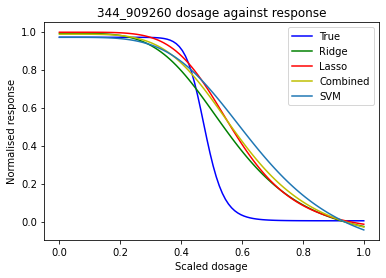

[-2.70468186  0.9954165   6.32766721 -0.0864821 ]


<ipython-input-7-2617c76f3ef4>:11: RuntimeWarning: divide by zero encountered in log
  return ( (a-d)/(1+np.exp(b*np.log(x)- c)) + d)
<ipython-input-7-2617c76f3ef4>:11: RuntimeWarning: divide by zero encountered in log
  return ( (a-d)/(1+np.exp(b*np.log(x)- c)) + d)
<ipython-input-7-2617c76f3ef4>:11: RuntimeWarning: divide by zero encountered in log
  return ( (a-d)/(1+np.exp(b*np.log(x)- c)) + d)
<ipython-input-7-2617c76f3ef4>:11: RuntimeWarning: divide by zero encountered in log
  return ( (a-d)/(1+np.exp(b*np.log(x)- c)) + d)
<ipython-input-7-2617c76f3ef4>:11: RuntimeWarning: divide by zero encountered in log
  return ( (a-d)/(1+np.exp(b*np.log(x)- c)) + d)


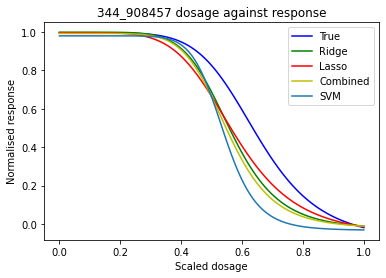

[-2.09321933e+01  9.79891815e-01  1.41493802e+01  1.23659031e-02]


<ipython-input-7-2617c76f3ef4>:11: RuntimeWarning: divide by zero encountered in log
  return ( (a-d)/(1+np.exp(b*np.log(x)- c)) + d)
<ipython-input-7-2617c76f3ef4>:11: RuntimeWarning: divide by zero encountered in log
  return ( (a-d)/(1+np.exp(b*np.log(x)- c)) + d)
<ipython-input-7-2617c76f3ef4>:11: RuntimeWarning: divide by zero encountered in log
  return ( (a-d)/(1+np.exp(b*np.log(x)- c)) + d)
<ipython-input-7-2617c76f3ef4>:11: RuntimeWarning: divide by zero encountered in log
  return ( (a-d)/(1+np.exp(b*np.log(x)- c)) + d)
<ipython-input-7-2617c76f3ef4>:11: RuntimeWarning: divide by zero encountered in log
  return ( (a-d)/(1+np.exp(b*np.log(x)- c)) + d)


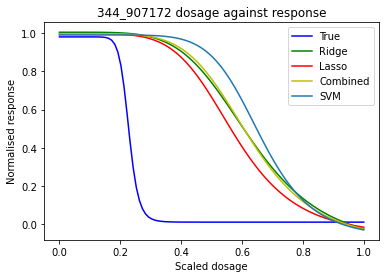

[-5.23858762  1.1098603  21.84854388 -0.02783268]


<ipython-input-7-2617c76f3ef4>:11: RuntimeWarning: divide by zero encountered in log
  return ( (a-d)/(1+np.exp(b*np.log(x)- c)) + d)
<ipython-input-7-2617c76f3ef4>:11: RuntimeWarning: divide by zero encountered in log
  return ( (a-d)/(1+np.exp(b*np.log(x)- c)) + d)
<ipython-input-7-2617c76f3ef4>:11: RuntimeWarning: divide by zero encountered in log
  return ( (a-d)/(1+np.exp(b*np.log(x)- c)) + d)
<ipython-input-7-2617c76f3ef4>:11: RuntimeWarning: divide by zero encountered in log
  return ( (a-d)/(1+np.exp(b*np.log(x)- c)) + d)
<ipython-input-7-2617c76f3ef4>:11: RuntimeWarning: divide by zero encountered in log
  return ( (a-d)/(1+np.exp(b*np.log(x)- c)) + d)


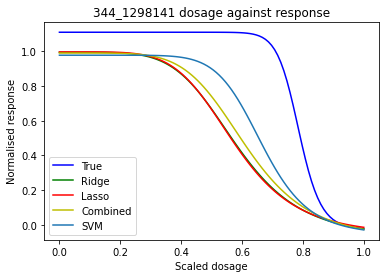

[-1.96794075e+01  9.97509462e-01  2.58489620e+01  4.84812845e-03]


<ipython-input-7-2617c76f3ef4>:11: RuntimeWarning: divide by zero encountered in log
  return ( (a-d)/(1+np.exp(b*np.log(x)- c)) + d)
<ipython-input-7-2617c76f3ef4>:11: RuntimeWarning: divide by zero encountered in log
  return ( (a-d)/(1+np.exp(b*np.log(x)- c)) + d)
<ipython-input-7-2617c76f3ef4>:11: RuntimeWarning: divide by zero encountered in log
  return ( (a-d)/(1+np.exp(b*np.log(x)- c)) + d)
<ipython-input-7-2617c76f3ef4>:11: RuntimeWarning: divide by zero encountered in log
  return ( (a-d)/(1+np.exp(b*np.log(x)- c)) + d)
<ipython-input-7-2617c76f3ef4>:11: RuntimeWarning: divide by zero encountered in log
  return ( (a-d)/(1+np.exp(b*np.log(x)- c)) + d)


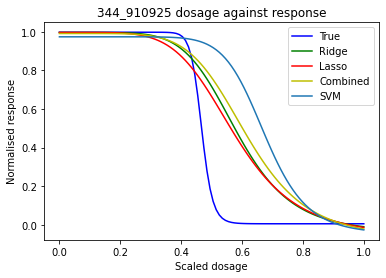

[-5.23858762  1.1098603  21.84854388 -0.02783268]


<ipython-input-7-2617c76f3ef4>:11: RuntimeWarning: divide by zero encountered in log
  return ( (a-d)/(1+np.exp(b*np.log(x)- c)) + d)
<ipython-input-7-2617c76f3ef4>:11: RuntimeWarning: divide by zero encountered in log
  return ( (a-d)/(1+np.exp(b*np.log(x)- c)) + d)
<ipython-input-7-2617c76f3ef4>:11: RuntimeWarning: divide by zero encountered in log
  return ( (a-d)/(1+np.exp(b*np.log(x)- c)) + d)
<ipython-input-7-2617c76f3ef4>:11: RuntimeWarning: divide by zero encountered in log
  return ( (a-d)/(1+np.exp(b*np.log(x)- c)) + d)
<ipython-input-7-2617c76f3ef4>:11: RuntimeWarning: divide by zero encountered in log
  return ( (a-d)/(1+np.exp(b*np.log(x)- c)) + d)


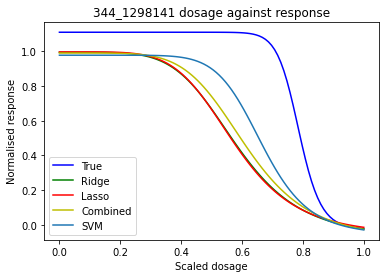

[-1.17265489e+01  9.80967674e-01  1.51631772e+01  4.60009456e-03]


<ipython-input-7-2617c76f3ef4>:11: RuntimeWarning: divide by zero encountered in log
  return ( (a-d)/(1+np.exp(b*np.log(x)- c)) + d)
<ipython-input-7-2617c76f3ef4>:11: RuntimeWarning: divide by zero encountered in log
  return ( (a-d)/(1+np.exp(b*np.log(x)- c)) + d)
<ipython-input-7-2617c76f3ef4>:11: RuntimeWarning: divide by zero encountered in log
  return ( (a-d)/(1+np.exp(b*np.log(x)- c)) + d)
<ipython-input-7-2617c76f3ef4>:11: RuntimeWarning: divide by zero encountered in log
  return ( (a-d)/(1+np.exp(b*np.log(x)- c)) + d)
<ipython-input-7-2617c76f3ef4>:11: RuntimeWarning: divide by zero encountered in log
  return ( (a-d)/(1+np.exp(b*np.log(x)- c)) + d)


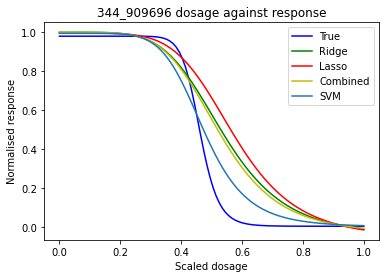

[-4.87963791  1.04331155  8.09625277  0.08848723]


<ipython-input-7-2617c76f3ef4>:11: RuntimeWarning: divide by zero encountered in log
  return ( (a-d)/(1+np.exp(b*np.log(x)- c)) + d)
<ipython-input-7-2617c76f3ef4>:11: RuntimeWarning: divide by zero encountered in log
  return ( (a-d)/(1+np.exp(b*np.log(x)- c)) + d)
<ipython-input-7-2617c76f3ef4>:11: RuntimeWarning: divide by zero encountered in log
  return ( (a-d)/(1+np.exp(b*np.log(x)- c)) + d)
<ipython-input-7-2617c76f3ef4>:11: RuntimeWarning: divide by zero encountered in log
  return ( (a-d)/(1+np.exp(b*np.log(x)- c)) + d)
<ipython-input-7-2617c76f3ef4>:11: RuntimeWarning: divide by zero encountered in log
  return ( (a-d)/(1+np.exp(b*np.log(x)- c)) + d)


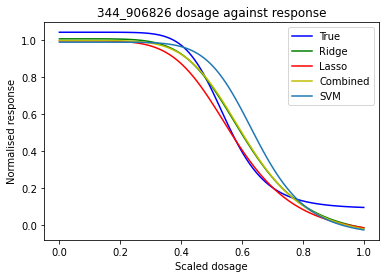

[-0.35781568  1.0025294   3.97313824 -0.74137014]


<ipython-input-7-2617c76f3ef4>:11: RuntimeWarning: divide by zero encountered in log
  return ( (a-d)/(1+np.exp(b*np.log(x)- c)) + d)
<ipython-input-7-2617c76f3ef4>:11: RuntimeWarning: divide by zero encountered in log
  return ( (a-d)/(1+np.exp(b*np.log(x)- c)) + d)
<ipython-input-7-2617c76f3ef4>:11: RuntimeWarning: divide by zero encountered in log
  return ( (a-d)/(1+np.exp(b*np.log(x)- c)) + d)
<ipython-input-7-2617c76f3ef4>:11: RuntimeWarning: divide by zero encountered in log
  return ( (a-d)/(1+np.exp(b*np.log(x)- c)) + d)
<ipython-input-7-2617c76f3ef4>:11: RuntimeWarning: divide by zero encountered in log
  return ( (a-d)/(1+np.exp(b*np.log(x)- c)) + d)


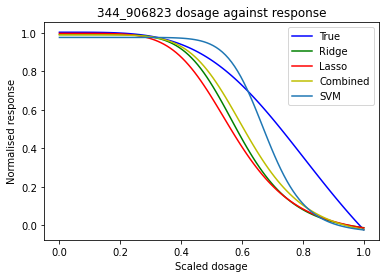

In [20]:
max_int = len(combinedOptimal.index)
rand_int = np.random.randint(0, max_int, 9)
for index in rand_int:
    showTestPredResponses(combinedOptimal.loc[index]['DRUG_COSMICID'])